## Stokes Flow in Periodic Channel with Robin boundary.

In [1]:
import sys
sys.path.append('/home/emastr/phd/')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"#"last_expr_or_assign"

import numpy as np
import matplotlib.pyplot as plt
from util.logger import EventTracker
from util.basis_scaled import *
from util.plot_tools import *
from boundary_solvers.gauss_grid_2d import StokesDirichletProblem
from scipy.io import loadmat
import matplotlib.pyplot as plt
from util.interp import PiecewiseInterp2D
from hmm.stokes import *
from hmm.stokes_deep import DeepMicroSolver, get_net
import matplotlib

matplotlib.rcParams['text.usetex'] = True

pretty_pyplot_layout()

## Multiscale Problem

We define a multiscale problem as follows. The PDE is a non-slip zero forcing Stokes flow Problem

\begin{equation}
\Delta u  - \nabla p = 0, \qquad \qquad \nabla \cdot u = 0   \qquad \text{inside}\quad \Omega
\end{equation}

with the boundary conditions

\begin{equation}
u = g,\qquad \text{on}\quad\partial\Omega
\end{equation}

the boundary is a two-dimensional pipe with corners at (0,-1) and (1,1), and a micro scale boundary:

In [2]:
i = 34 #41 # 38 #41 #35 #11 #38 #22 
data, info = StokesData.load_from_matlab(f"/home/emastr/phd/data/reference_2/run_{i}.mat")
data_big_domain = data
dom = data.dom
eval_pos = info["eval_pos"]
eps = info["eps"]
nper = info["nper"]
Lx = info["Lx"]
bbox = info["bbox"]
Uc = info['Uc']
Vc = info['Vc']
Uyc = info['Uyc']

x = np.linspace(bbox[0][0],bbox[0][1],Uc.shape[0])
y = np.linspace(bbox[1][0],bbox[1][1],Uc.shape[1])
X,Y = np.meshgrid(x,y)

pwlerp = PiecewiseInterp2D(x, y, Uc)
pwlerp_dy = PiecewiseInterp2D(x, y, Uyc)
pwlerp_alpha = lambda x: -pwlerp(x, np.ones_like(x)*eval_pos) / pwlerp_dy(x, np.ones_like(x)*eval_pos)

### Load Network for evaluation

## Coupling to Micro Domain

To couple the macro domain to the microscopic domain, we make use of the HMM framework.
We construct a set of evenly spaced micro problems based on the Stokes data. The macro problem is constructed with a pre-specified resolution in the x- and y-directions.

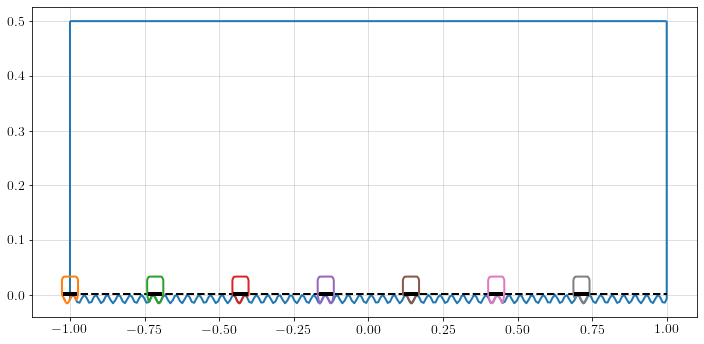

In [3]:
logger = EventTracker() # Log time

tol = 1e-10
#################
# Macro problem
#################

xDim = 21
yDim = 21
macro = StokesMacProb(data, lambda x,a: fft_interp(x, a, dom=dom[0]))
###################
# Micro problems
###################

nMic = 7 #freq_g*2+1#2*(round(Lx/(30*eps)) // 2) + 1 # 15 # 15 #nMic*2 +1
yDim_reduce=5
xDim_reduce=5
width= 5*eps #5*eps #3
height=width*0.8 #3
n_refine=0
#xPos = np.linspace(dom[0][0]+4*eps, dom[0][1]-4*eps, nMic)-2*eps
xPos = np.linspace(dom[0][0], dom[0][1], nMic+1)[1:] - width/2 - Lx / nMic/1
micros = [StokesMicProb(data, x, width, height, linePos=0.0, deg_project=8, logger=logger, 
                        n_refine=n_refine, xDim_reduce=xDim_reduce, yDim_reduce=yDim_reduce) for x in xPos]

###################
# Hmm problem.
conv_checker = ConvergenceChecker(macro, micros, tol=tol)
hmm_prob = StokesHMMProblem(macro, micros, data, convergence_checker=conv_checker)

hmm_prob.plot(plt.gca())


## Solving using HMM iterations

To solve the problem, we make use of a sequence of micro solvers, as well as a micro solver.

In [4]:
class Callback():
    def __init__(self, macro):
        self.N = 100
        self.x = np.linspace(-1,1.,self.N)
        self.macro = macro
        self.alphas =  [macro.alpha(self.x)]
        self.diff = []
    
    def __call__(self, it, macro_sol, micro_sols):
        self.alphas.append(self.macro.alpha(self.x))
        self.diff.append(np.linalg.norm(self.alphas[-1] - self.alphas[-2]) / self.N**0.5)
        
debug_cb = Callback(macro)
macro_solver = MacroSolver(xDim, yDim, tol=tol, logger=logger)

class CountCallback():
    def __init__(self):
        self.count = 0
    def __call__(self, *args):
        self.count += 1
counters = [CountCallback() for m in micros]
    
print("Classic precomputing...")
logger.start_event("Classic precomputing, total")
micro_solvers = [MicroSolver(m, logger=logger, tol=100*tol, callback=c) for m, c in zip(micros, counters)]
logger.end_event("Classic precomputing, total")
print("Done")
hmm_solver = IterativeHMMSolver(macro_solver, micro_solvers)

print([c.count for c in counters])

#macro.alpha = lambda x: 0.01*(1. + 0*np.sin(x*np.pi))
#macro_guess = macro_solver.solve(macro)
#debug_cb.diff = []

#print("Classic HMM Solver...")
#logger.start_event("Classic HMM Solver, total")
#(macro_sol, micro_sols) = hmm_solver.solve(hmm_prob, macro_guess=macro_guess, 
#                                          callback=debug_cb, verbose=True, maxiter=20, tol=tol, logger=logger)
#logger.end_event("Classic HMM Solver, total")
#print("\nDone")

def T(a):
    """Fix point iteration starting in slip coefficient"""
    macro.alpha = a
    macro_sol = macro_solver.solve(macro)
    [m.update(macro_sol) for m in micros]
    micro_sols = [s(m) for m,s in zip(micros, micro_solvers)]
    a, x = [m.alpha for m in micro_sols], [m.x for m in micro_sols]
    return fft_interp(x, a, dom=dom[0])

def get_U(a):
    """Macro solution given alpha"""
    macro.alpha = a
    macro_sol = macro_solver.solve(macro)
    return macro_sol
    
def R(U):
    """Fix point iteration starting in macro solution"""
    [m.update(U) for m in micros]
    micro_sols = [s(m) for m,s in zip(micros, micro_solvers)] 
    macro.update(micro_sols)
    U = macro_solver.solve(macro)
    return U  



def macro_norm(u, v):
    dux, duy = u.diff(1, 0), u.diff(0, 1)
    dvx, dvy = v.diff(1, 0), v.diff(0, 1)
    du2 = dux*dux + duy*duy + dvx*dvx + dvy*dvy
    u2 = u*u + v*v
    normu = du2 #+ u2
    return np.mean(normu.eval_grid()) ** 0.5


Classic precomputing...
Done
[20, 23, 19, 22, 19, 24, 20]


#### Contraction property of $R:U\to U$

Check that $\|T(a) - T(b)\| \leq \gamma \|a-b\|$

In [5]:
macro.alpha = lambda x: (2 + 1.8*np.sin(x*8*np.pi)) * 0.0055
U1 = macro_solver.solve(macro)

macro.alpha = lambda x: (2 - 0.1*np.cos(x*2*np.pi)) * 0.01
U2 = macro_solver.solve(macro)


RU1 = R(U1)
RU2 = R(U2)

print(macro_norm(U1.u-U2.u, U1.v-U2.v))
print(macro_norm(RU1.u-RU2.u, RU1.v-RU2.v))

0.35666014640308563
0.0009898426835961958


#### Dependence of $\|\partial_n T\|$ on $\epsilon$ (TODO)

In [6]:
eps = np.logspace(-3, -1, 10)

for e in eps:
    macro.alpha = lambda x: np.ones_like(x) * e
    sol = macro_solver.solve(macro)
    duy = sol.u.diff(0, 1)
    duy
    

#### Local Contraction property: $\|\partial T(a\colon b)\| \leq 1$

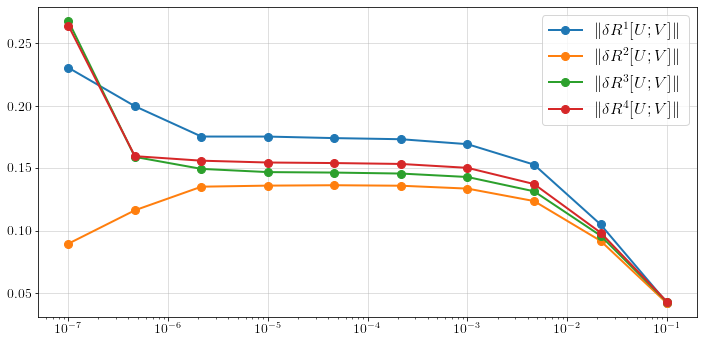

In [7]:
for n in [1,2,3,4]:
    macro.alpha = lambda x: (2 + 0.5*np.sin(x*8*np.pi)) * 0.05
    U1 = macro_solver.solve(macro)
    for i in range(n):
        U1 = R(U1)#R(R(R(R(U1))))

    macro.alpha = lambda x: (2 - 0.1*np.cos(x*2*np.pi)) * 0.01
    U2 = macro_solver.solve(macro)
    for i in range(n):
        U2 = R(U2)#R(R(R(R(U1))))

    u, v = U1.u, U1.v
    du, dv = U2.u - u, U2.v - v
    c = 1 / macro_norm(du, dv)
    du, dv = c * du, c * dv


    hs = np.logspace(-7, -1, 10)
    er = []
    for h in hs:
        U2.u = u + h * du
        U2.v = v + h * dv

        RU2 = R(U2)
        RU1 = R(U1)

        dRu = (1/h) * (RU2.u - RU1.u)
        dRv = (1/h) * (RU2.v - RU1.v)
        er.append(macro_norm(dRu, dRv))
        
    plt.semilogx(hs, er, 'o-', label = "$\|\delta R^{" + str(n) + "}[U; V]\|$")
plt.legend()

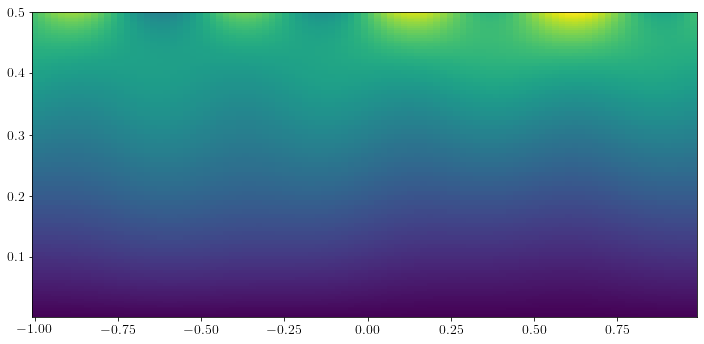

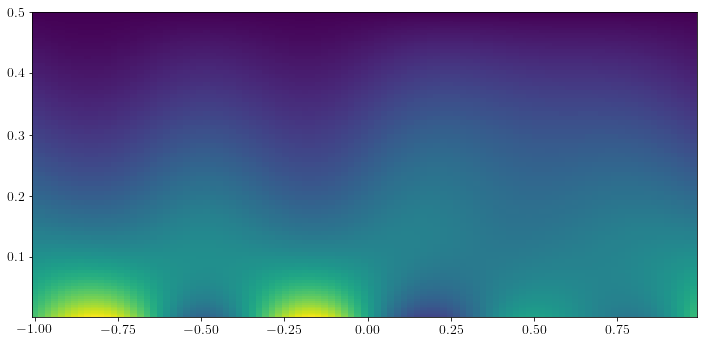

In [8]:
plt.figure()
u.change_dim(101,101).plot(plt.gca())#, vmin=-.02, vmax=.02)

plt.figure()
dRu.change_dim(101,101).plot(plt.gca())#, vmin=-.02, vmax=.02)



### Plot difference of $\alpha$ over iterations

In [9]:
a1 = lambda x: (2 + 1.8*np.sin(x*8*np.pi)) * 0.0005
a2 = lambda x: (2 - 1.1*np.cos(x*2*np.pi)) * 0.001

x = np.linspace(-1,1,100)
a1s = [a1(x)]
a2s = [a2(x)]

for i in range(4):
    a1, a2 = T(a1), T(a2)
    a1s.append(a1(x))
    a2s.append(a2(x))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


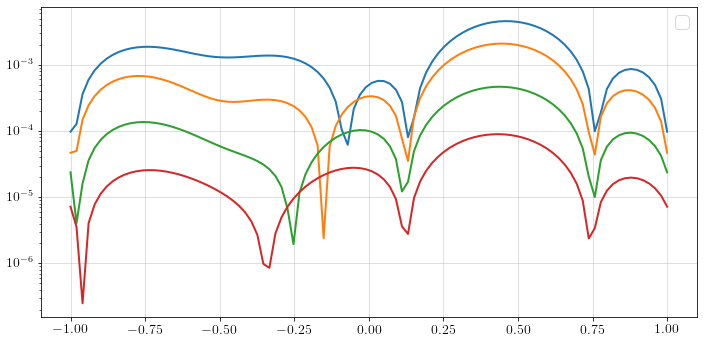

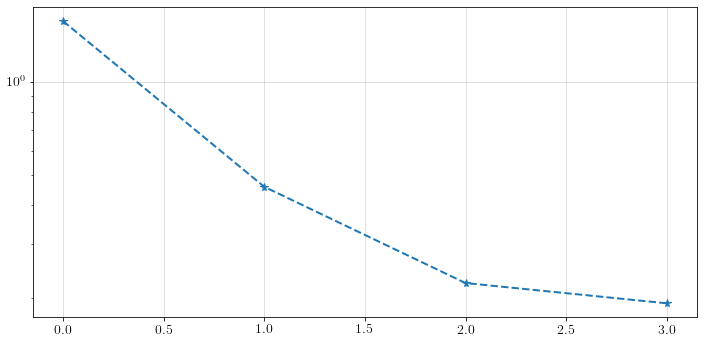

In [10]:
def norm(x, p):
    return np.sum(np.abs(x)**p)**(1/p)

x = np.linspace(-1, 1, 100)
rel_err = []
p = 10
for i in range(1,len(a1s)):
    plt.plot(x, np.abs(a1s[i]-a2s[i]))
    rel_err.append(norm(a1s[i]-a2s[i], p) / norm(a1s[i-1]-a2s[i-1], p))
plt.legend()
plt.yscale("log")

plt.figure()
plt.semilogy(rel_err, '*--')


### Difference in solution as function of increment, $\delta[||\nabla u(\alpha)||, \alpha \colon \eta]$

It can be proven that the seminorm $\| \nabla u \|$ is decreasing for non-negative changes in the slip coefficient. This proof only works locally at $\alpha = 0$.

Norm difference: -5.670493854449532


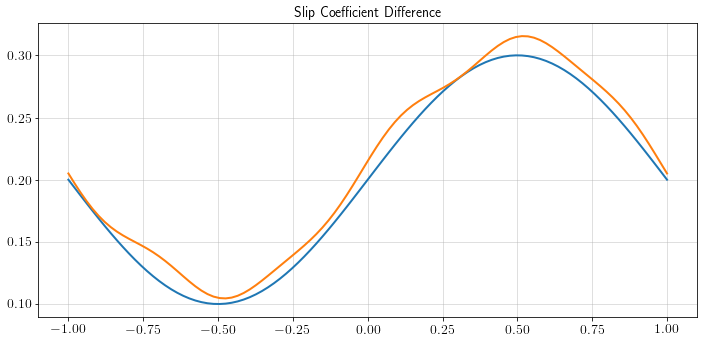

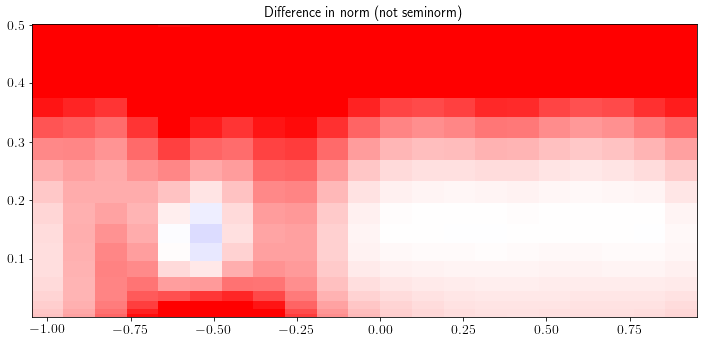

In [92]:
alpha = lambda x: 0.2*(1. + 0.5*np.sin(1*x*np.pi)) # Slip coefficient
eta = lambda x: (1. + 0.5*np.sin(5*x*np.pi) + 0.5*np.cos(3*x*np.pi)) # Increment
t = 0.01

def wsum(a, b, weight):
    return lambda x: a(x) + weight * b(x)

U = get_U(alpha)
V = get_U(wsum(alpha, eta, t))

Unorm = (U.u.diff(1, 0)**2 + U.u.diff(0, 1)**2 + U.v.diff(1, 0)**2 + U.v.diff(0, 1)**2) ** 0.5
Vnorm = (V.u.diff(1, 0)**2 + V.u.diff(0, 1)**2 + V.v.diff(1, 0)**2 + U.v.diff(0, 1)**2) ** 0.5

print(f"Norm difference: {1/t * (np.mean(Unorm.eval_grid()) - np.mean(Vnorm.eval_grid()))}")

x = np.linspace(-1, 1, 100)
plt.plot(x, alpha(x))
plt.plot(x, alpha(x) + t * eta(x))
plt.title("Slip Coefficient Difference")

plt.figure()
plt.title("Difference in norm (not seminorm)")
(U.v**2 - V.v**2 + 0.01*(U.u**2 - V.v**2)).plot(plt.gca(), vmax=0.001, vmin=-0.001, cmap="bwr")


### Convergence and computation time

In [12]:
plt.figure(figsize=(15,10))


for i in range(1,6):
    alpha1 = debug_cb.alphas[i]
    alpha2 = debug_cb.alphas[i-1]
    
    plt.subplot(211)    
    plt.plot(debug_cb.x, -alpha1.real)
    
    plt.subplot(212)
    plt.plot(debug_cb.x, (alpha2-alpha1).real)

IndexError: list index out of range

<Figure size 1080x720 with 0 Axes>

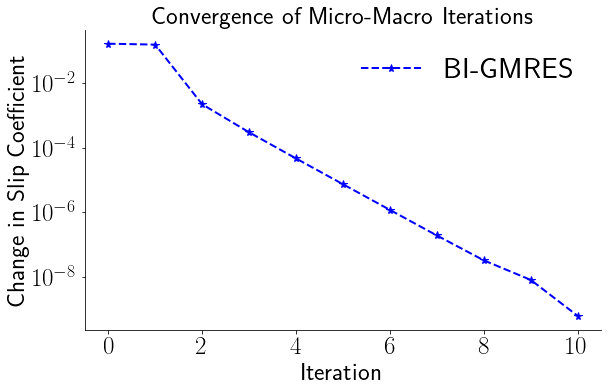

In [ ]:
plt.figure(figsize=(9,6))
matplotlib.rcParams.update({'font.size': 25})

plt.title("Convergence of Micro-Macro Iterations")
plt.semilogy(debug_cb.diff, 'b*--', label='BI-GMRES')
plt.legend(loc='upper right', frameon=False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.grid(False)
plt.xlabel("Iteration")
plt.ylabel("Change in Slip Coefficient")
plt.gcf().savefig("/home/emastr/phd/data/figures_math4dl/convergence.pdf", bbox_inches='tight')
